# Control variates for a GARCH model

Python translation from the programm of : https://github.com/tianhanguan/Markov_Chain_Monte_Carlo_methods

## Libraries set up

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import os

In [2]:
os.chdir("/Users/ludovic/Desktop/ENSAE/S2/MC/Garch_ZV_MCMC") #set up the location of the project 

## Q1 : Implementation of a random walk Metropolis sampler that targets the posterior distribution of a GARCH model

### Test with simulated data

#### Simulation of data following a GARCH(1,1) process

The following code is used to simulate a GARCH(1,1) model with N data points 

In [4]:
N = 5000  #Run size
n = 1000  #Burn-in size
a = [0.8, 0.2, 0.5] # parameters of the GARCH model : omega, alpha, beta 

Generate the GARCH(1,1) process iteratively by its definition. A process $r_{t}$ folows a Garch representation if :

$r_{t}=z_{t}*\sqrt{h_{t}}$,

$h_{t} = \omega + \alpha*r_{t-1}^2 + \beta*h_{t-1}$,

Where $z_{t}$ is a weak white noise,

And $\omega>0$, $\alpha>0$, $\beta>0$

GARCH, Generalized Autoregressive Conditional Heteroskedasticity, suppose volatility of time t affects volatility of t+1. The volatility is thus not constant. $h_t$ is thus the variance of $r_t$ knowing the volatility and the GARCH value of all the previous period. 

PS : We could have defined $y = c + r_{t}$ with c a constant

In [5]:
def garch_11(parameters, N):   #Size of the generated data
    r = np.zeros(N)  # r corresponds to the Garch process
    h = np.zeros(N)  # h corresponds to the volatility : h=sigma^2

    # We define the initial values of e and h 
    r[0] = 0.1
    h[0] = 0.01

    WN = np.random.normal(0, 1, N)  # noise follows a Normal(0,1)

    for i in range(1, N):
        h[i] = parameters[0] + parameters[1] * r[i-1]**2 + parameters[2] * h[i-1]
        r[i] = np.sqrt(h[i]) * WN[i]

    return r,h

Simulated true data of the previously defined GARCH(1,1) process

In [6]:
r_garch = garch_11(a, N)[0][(n + 1):N]

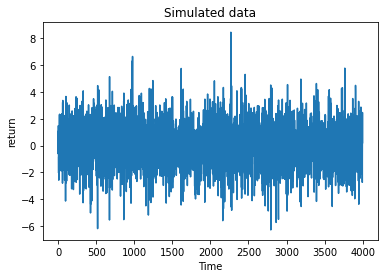

In [5]:
plt.plot(r_garch)
plt.title('Simulated data')
plt.xlabel('Time')
plt.ylabel('return')
plt.show()

In [7]:
h_garch = garch_11(a, N)[1][(n + 1):N]

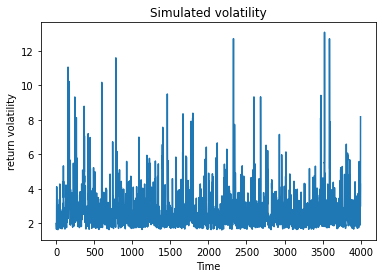

In [7]:
plt.plot(h_garch)
plt.title('Simulated volatility')
plt.xlabel('Time')
plt.ylabel('return volatility')
plt.show()

#### MCMC

We define the density distribution of our target function "a une constante près" with a centered normal distribution for one point of the time series. $r_{t}|F_{t-1}$, the garch process, is indeed supposed to follow a normal law distribution $(0,h_{t})$. We define the log likelihood by iteration at each time of the simulated data to find the density of a combination of parameter on all the Garch process. 

It is important to fix the right initial h in the following function. After trying different h, it turns out that this parameter is really decisive for the estimator to converge. The question is how to fix the right h when we have real data.

Function to iteratively calculate the logged posterior distribution :

In [245]:
def g0(r, h):
    return -0.5 * np.log(h) - 0.5 * (r**2 / h) # Normal law because r_{t}|F_t-1 follow N(0,h_t)

def g(x , data, h_initial):
    h = h_initial # How to fix h? Proposition : max g0 initial
    LL = g0(data[0],h) # density is initialized with our first simulated data

    for i in range(1, len(data)):
        h = x[0] + x[1] * data[i-1]**2 + x[2] * h
        LL += g0(data[i],h)

    return LL

Determination of sigma(volatility for the proposal function): we look for the right order of magnitude of sigma by studying the ratio of densities. If this ratio is either very close to 0 or extremely large which could mean that the difference between X and Y is too large and sigma should be lower. the risk of lowering sigma too much is to have a too high acceptance rate and a too high dependency between the links in the chain. The procedure used is therefore to find the order of magnitude of sigma by seeking to obtain a ratio between 0 and 20, fairly evenly distributed, and then validate sigma by running the algorithm and validating a posteriori acceptance rate between 0.2 and 0.6.

In [73]:
print("X :", X)
a=g(X, data = r_garch, h_initial = 0.01)
print("g(X):", a)
Y = X + np.random.normal(loc=0, scale=0.011, size=3)
print("Y:",Y)
b=g(Y, data = r_garch, h_initial = 0.01)
print("g(Y):",b)
X=Y
U = np.random.rand(1)
print("ln(U) : ",np.log(U))
print("différence : ", b-a)
print((b-a) > np.log(U))

print("exp(g(X)) : " ,np.exp(a))
print("exp(g(Y)) : " ,np.exp(b))
print("U : ",U)
print("ratio : ", np.exp(b-a))

X : [0.78077234 0.22104115 0.4992527 ]
g(X): -4626.217549207794
Y: [0.77738633 0.22638043 0.48899424]
g(Y): -4626.744514820145
ln(U) :  [-0.49538584]
différence :  -0.5269656123509776
[False]
exp(g(X)) :  0.0
exp(g(Y)) :  0.0
U :  [0.60933576]
ratio :  0.5903937378640373
[False]


We define the parameters that will be used in the algorithm :

In [74]:
M = 3000 # size of the desired sample
#X = np.random.rand(3) # Random starting point for the Markov chain (dim=3)
X= [0.89640571, 0.62853914, 0.09766534] # Deterministic starting point for the Markov chain (dim=3)
sigma = 0.011  # volatility for the proposal function (fixed by looking for an acceptance rate between 0.3 and 0.6)
x1list = []  # for keeping track of omega values
x2list = [] # for keeping track of alpha values
x3list = [] # for keeping track of beta values
numaccept = 0 # counts the number of acceptance in the accept/rejct algorithm
i = 0 #initialization of i, the total number of iteration 

The goal is to draw more times a combination of the 3 parameters where the loglikelyhoood is large so that we can approximate precisely the expectation of the sample, ie the value of the parameters that match our data. We define a combination of 3 parameters X and a new combination Y. Y is a normal deviation from X of volatility sigma. When the density, i.e. the likelihood, is higher for the combination Y than for the combination X, we accept, because we are heading towards a location where Y corresponds probably more to the parameter combination that fits our data than the X combination was. If the probability density for the combination Y is lower than the probability density for the combination X then we accept only if their ratio (thus lower than 1) is higher than U, drawing from a uniform law between 0 and 1. Moreover we reject directly if at least one of the 3 parameters of Y is negative.

Warning : we apply log to the density, so it is not a ratio but a difference.

By repeating this algorithm a certain number of times we will get more frequently combinations that fit our data than others. We can also restart the algorithm from the beginning with a new initial X, a certain number of times, to better approximate the parameter combination.

Algorythm :

In [75]:
while numaccept < M:
    Y = X + np.random.normal(loc=0, scale=sigma, size=3)  # Proposal move with a normal distribution (dim=3 because 3 parameters)
    U = np.log(np.random.rand(1)) # Random draw in a uniform distribution for accept/reject
    if np.all(Y > 0): # Reject all samples where any parameter is negative
        alpha = g(Y, data = r_garch, h_initial = 0.01) - g(X, data = r_garch, h_initial = 0.01)  # Difference between current and previous density accept/reject
        if U < alpha:  # Reject if the ratio of densities is lower than a draw in a uniform distribution
            X = Y  # Accept proposal
            numaccept += 1 # Counts the number of acceptance in the accept/reject algorithm
    
            x1list.append(X[0])   # Add the values to the lists of omega
            x2list.append(X[1])   # Add the values to the lists of alpha
            x3list.append(X[2])   # Add the values to the lists of beta
    
    # Output progress report (can be long)
    i += 1 # Counts the number of total iteration 
    if (i % 1000) == 0:
        print(" ...", i)

 ... 1000
 ... 2000
 ... 3000
 ... 4000
 ... 5000


#### Exploitation of the results

We plot a visualization of the estimator series to see the evolution of X in the algorythm and the size of the burn in required.

We note on these graph that omega and beta goes often on opposite direction.

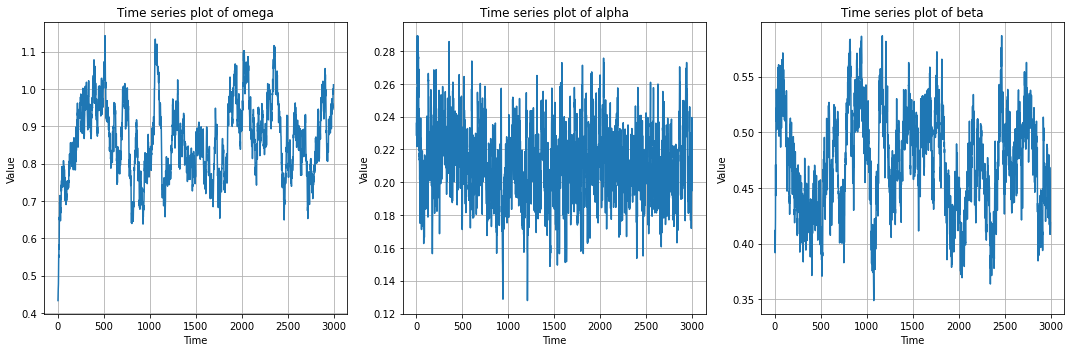

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot time series graphs for x1list, x2list and x3list
axs[0].plot(x1list)
axs[0].set_title("Time series plot of omega")
axs[1].plot(x2list)
axs[1].set_title("Time series plot of alpha")
axs[2].plot(x3list)
axs[2].set_title("Time series plot of beta")

# Title and grid settings for time series charts
for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)

# Display time series graphs side by side
plt.tight_layout()
plt.show()

We choose a large enough value of burn in to exclude the part of the chain which had probably a low density :

In [77]:
B = 600  # amount of burn-in

We plot the density of the sample for each parameters :

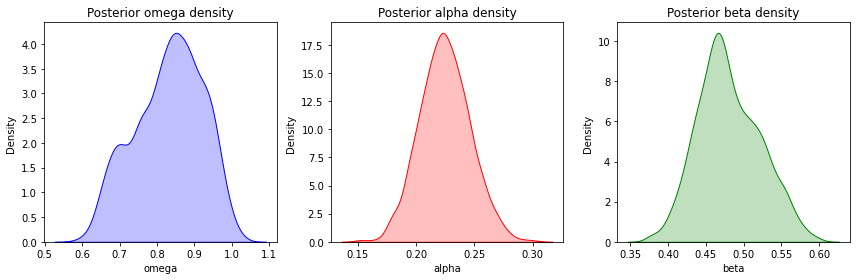

In [78]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# plot omega
sns.kdeplot(x1list[(B):(len(x1list))], fill=True, color='b', ax=axes[0])
axes[0].set_xlabel('omega')
axes[0].set_ylabel('Density ')
axes[0].set_title('Posterior omega density')

# plot alpha
sns.kdeplot(x2list[(B):(len(x2list))], fill=True, color='r', ax=axes[1])
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('Density ')
axes[1].set_title('Posterior alpha density')

# plot beta
sns.kdeplot(x3list[(B):(len(x3list))], fill=True, color='g', ax=axes[2])
axes[2].set_xlabel('beta')
axes[2].set_ylabel('Density ')
axes[2].set_title('Posterior beta density')

# space between subgraphs
plt.tight_layout()

# Display
plt.show()

x1 and x3 are sometimes badly estimated because they can contradict each other and lead with false values to a density function higher than the density function taking the right values.

In [21]:
print(g([0.8,0.2,0.5], data = r_garch, h_initial=0.01)) # the supposed min of the posterior density function
print(g([0.9,0.2,0.49], data = r_garch, h_initial=0.01)) # When omega and beta go on opposite direction
print(g([0.9,0.2,0.47], data = r_garch, h_initial=0.01)) # When beta goes even further in the wrong direction, 
#function increases and can be the superior to what is supposed to be the min

-3905.044488501484
-3907.0156933308976
-3904.9860642325516


We can now determine the parameters by averaging the sample over the values that do not belong to the burn in :

In [79]:
print("ran Metropolis algorithm for", M, "iterations, with burn-in", B)
print("acceptance rate =", numaccept/i)
u = np.mean(x1list[B:len(x1list)])
print("mean of x1 is about", u)
v = np.mean(x2list[B:len(x2list)])
print("mean of x2 is about", v)
w = np.mean(x3list[B:len(x3list)])
print("mean of x3 is about", w)

ran Metropolis algorithm for 3000 iterations, with burn-in 600
acceptance rate = 0.540443163393983
mean of x1 is about 0.8307813573893086
mean of x2 is about 0.22462089682612021
mean of x3 is about 0.4803969155580827


Warning : the rejection rate (1-acceptance rate) takes into account the rejections due to a negative parameters. In this example Y rarely takes negative values because the true parameters are far enough from 0. However, with true data, we can have parameters close to 0 and therefore often have Y rejected because at least one of its parameters is negative. We will therefore present an alternative way to code the algorithm in the next part of the question, when we will estimate a real series, in order not to take into account in the rejection rate the Y rejected because of a negative value.

We calculate the standard error and the true standard error to determine the confidence intervals of our estimators:

In [62]:
def varfact(x): # function to get a variance factor used to obtain true standard error (because of the serial correlationn)
    acf_vals = acf(x, nlags=None, fft=True)  # acf comutation
    var_factor = 2 * np.sum(acf_vals) - 1  # variance factor computation
    return var_factor

In [63]:
# Computation the standard deviations of the x1list, x2list and x3list
se11 = np.std(x1list[(B):(len(x1list))]) / np.sqrt(len(x1list)-B)
se12 = np.std(x2list[(B):(len(x2list))]) / np.sqrt(len(x2list)-B)
se13 = np.std(x3list[(B):(len(x3list))]) / np.sqrt(len(x3list)-B)

# Compute the variance factor of the x1list, x2list and x3list
thevarfact1 = varfact(x1list[(B):(len(x1list))])
thevarfact2 = varfact(x2list[(B):(len(x2list))])
thevarfact3 = varfact(x3list[(B):(len(x3list))])

# Compute the true standard errors of the x1list, x2list and x3list
se1 = se11 * np.sqrt(thevarfact1)
se2 = se12 * np.sqrt(thevarfact2)
se3 = se13 * np.sqrt(thevarfact3)

# Display and compute the 95% confidencce interval
print("true standard error of omega is about", se1)
print("approximate 95% confidence interval of omega is (", u - 1.96 * se1, ",", u + 1.96 * se1, ")\n")

print("true standard error of alpha is about", se2)
print("approximate 95% confidence interval of alpha is (", v - 1.96 * se2, ",", v + 1.96 * se2, ")\n")

print("true standard error of beta is about", se3)
print("approximate 95% confidence interval of beta is (", w - 1.96 * se3, ",", w + 1.96 * se3, ")\n")

true standard error of omega is about 0.013532811736822426
approximate 95% confidence interval of omega is ( 0.7683310064998988 , 0.8213796285082428 )

true standard error of alpha is about 0.0023415909631534036
approximate 95% confidence interval of alpha is ( 0.21421039856339308 , 0.22338943513895443 )

true standard error of beta is about 0.0057098519327771725
approximate 95% confidence interval of beta is ( 0.48728546626687835 , 0.5096680858433649 )



Folowing graphs display the correlation between value in the series to ensurre that there is no to much dependancce between values.

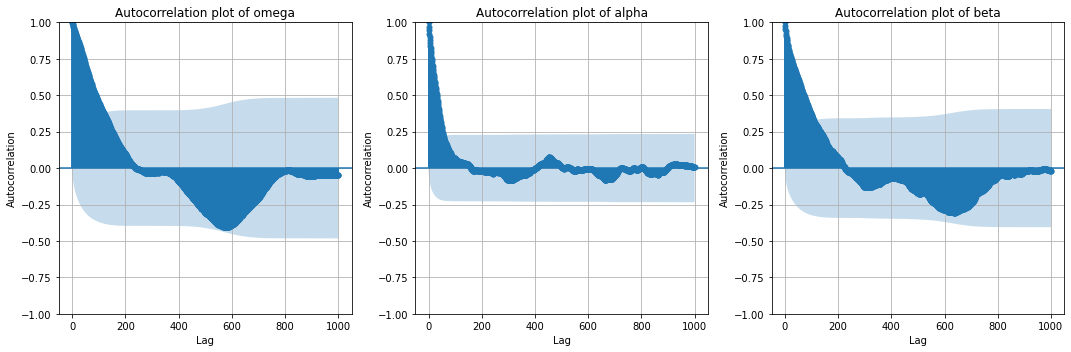

In [76]:
# Créer une nouvelle figure avec une grille de 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Tracer les graphiques d'autocorrélation pour x1list, x2list et x3list
plot_acf(x1list, ax=axs[0], lags=1000)
axs[0].set_title("Autocorrelation plot of omega")
plot_acf(x2list, ax=axs[1], lags=1000)
axs[1].set_title("Autocorrelation plot of alpha")
plot_acf(x3list, ax=axs[2], lags=1000)
axs[2].set_title("Autocorrelation plot of beta")

# Réglages des titres et de la grille pour les graphiques d'autocorrélation
for ax in axs:
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.grid(True)

# Afficher les graphiques d'autocorrélation côte à côte
plt.tight_layout()
plt.show()

### Test with real data

#### Return on exchange rate

We import real data, euro/dollar exchange rates in order to test the MCMC in a rigorous way:

In [418]:
data = pd.read_csv("euro-daily-hist_1999_2022.csv")
data.columns

Index(['Period\Unit:', '[Australian dollar ]', '[Bulgarian lev ]',
       '[Brazilian real ]', '[Canadian dollar ]', '[Swiss franc ]',
       '[Chinese yuan renminbi ]', '[Cypriot pound ]', '[Czech koruna ]',
       '[Danish krone ]', '[Estonian kroon ]', '[UK pound sterling ]',
       '[Greek drachma ]', '[Hong Kong dollar ]', '[Croatian kuna ]',
       '[Hungarian forint ]', '[Indonesian rupiah ]', '[Israeli shekel ]',
       '[Indian rupee ]', '[Iceland krona ]', '[Japanese yen ]',
       '[Korean won ]', '[Lithuanian litas ]', '[Latvian lats ]',
       '[Maltese lira ]', '[Mexican peso ]', '[Malaysian ringgit ]',
       '[Norwegian krone ]', '[New Zealand dollar ]', '[Philippine peso ]',
       '[Polish zloty ]', '[Romanian leu ]', '[Russian rouble ]',
       '[Swedish krona ]', '[Singapore dollar ]', '[Slovenian tolar ]',
       '[Slovak koruna ]', '[Thai baht ]', '[Turkish lira ]', '[US dollar ]',
       '[South African rand ]'],
      dtype='object')

Log transformation to get the return of the exchange rate:

In [1033]:
exchange_rate = pd.to_numeric(data['[UK pound sterling ]'], errors='coerce').astype(float)
s_t = exchange_rate[1:].reset_index(drop = True)
s_t_1 = exchange_rate[:-1].reset_index(drop = True)
rendement = np.log(s_t/s_t_1) #variation of exchange rate corresponds to the return
rendement = np.array(rendement)
rendement = rendement[2000:6000] # take just a portion of it because large CPU time 
rendement=rendement*100 #take it inn percenntage to not have parameters to close from 0

We can see on the following plot that the volatily is not constant and depend from previous perriod. So a Garch model is adapted.

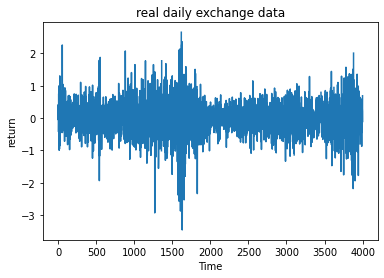

In [1034]:
plt.plot(rendement)
plt.title('real daily exchange data')
plt.xlabel('Time')
plt.ylabel('return')
plt.show()

There are missing values :

In [1035]:
np.sum(np.isnan(rendement))

103

We basically delete them:

In [1036]:
rendement = rendement[~np.isnan(rendement)]

#### MCMC

We seek for the right initial h firstly thanks to the max of g0 for the first value of the series:

In [1134]:
for h in np.arange(0.1, 0.3, 0.01):
    print(round(h,2)," :", g0(rendement[0],h))

0.1  : 0.3467469897409232
0.11  : 0.37223240499840626
0.12  : 0.3896771374699626
0.13  : 0.40122921675858536
0.14  : 0.4083810305034882
0.15  : 0.4121962879388743
0.16  : 0.41344975890159286
0.17  : 0.41271632875646735
0.18  : 0.4104294602925747
0.19  : 0.4069205735391941
0.2  : 0.4024461778390004
0.21  : 0.3972069423437154
0.22  : 0.3913613405166607
0.23  : 0.385035569048558
0.24  : 0.37833086250503145
0.25  : 0.3713289578575056
0.26  : 0.36409622523095875
0.27  : 0.35668682415628883
0.28  : 0.3491451390649797
0.29  : 0.3415076756711193


In [1135]:
print("X :", X)
a=g(X, data = rendement, h_initial = 0.16)
print("g(X):", a)
Y = X + np.random.normal(loc=0, scale= 0.001, size=3)
print("Y:",Y)
b=g(Y, data = rendement, h_initial = 0.16)
print("g(Y):",b)
X=Y
U = np.random.rand(1)
print("ln(U) : ",np.log(U))
print("différence : ", b-a)
print((b-a) > np.log(U))

print("exp(g(X)) : " ,np.exp(a))
print("exp(g(Y)) : " ,np.exp(b))
print("U : ",U)
print("ratio : ", np.exp(b-a))
print((np.exp(b-a))> U)

X : [0.00199661 0.05967515 0.93065122]
g(X): 1263.85027350805
Y: [0.00233453 0.06057956 0.93103704]
g(Y): 1263.2145001783376
ln(U) :  [-0.55959027]
différence :  -0.635773329712265
[False]
exp(g(X)) :  inf
exp(g(Y)) :  inf
U :  [0.57144315]
ratio :  0.5295258318790326
[False]


/var/folders/jy/77k463fj5d94h9zj3_qn_glh0000gn/T/ipykernel_16706/1124741199.py:14: RuntimeWarning: overflow encountered in exp
  print("exp(g(X)) : " ,np.exp(a))
/var/folders/jy/77k463fj5d94h9zj3_qn_glh0000gn/T/ipykernel_16706/1124741199.py:15: RuntimeWarning: overflow encountered in exp
  print("exp(g(Y)) : " ,np.exp(b))


With these data, it is important to choose the initial X in an adequate way contrary to simulated data. It is necessary to choose the initial X close to the good parameters, because we are forced to put a very small sigma to have a viable acceptance rate here. So to find the right X we must repeat the algorithm several times and analyze the graphs of the series to see where the parameters converge.

In [1108]:
#X = np.random.rand(3) # Random starting point for the Markov chain (dim=3)
X = [0.02, 0.05, 0.9] #appropriate initial X for the markov chain
sigma = 0.001  # volatility for the proposal function (fixed by looking for an acceptance rate between 0.3 and 0.6)
x1list = []  # for keeping track of omega values
x2list = [] # for keeping track of alpha values
x3list = [] # for keeping track of beta values
numaccept = 0 # counts the number of acceptance in the accept/rejct algorithm
i = 0 #initialization of i
h=0.16 #initial series volatility

In [1109]:
while numaccept < 5000:
    
    Y = X + np.random.normal(loc=0, scale=sigma, size=3) # Proposal move with a normal distribution (dim=3 because 3 parameters)
    while np.any(Y <= 0): # Reject all samples where any parameter is negative (but so that it is not counted in the acceptance rate)
        Y = X + np.random.normal(loc=0, scale=sigma, size=3)  
    
    U = np.log(np.random.rand(1)) # Random draw in a uniform distribution for accept/reject
    alpha = g(Y, data = rendement, h_initial = h) - g(X, data = rendement, h_initial = h)  # Difference between current and previous density accept/reject
    
    if U < alpha:  # Reject if the ratio of densities is lower than a draw in a uniform distribution
        X = Y # Accept proposal
        numaccept += 1 # Counts the number of acceptance in the accept/reject algorithm

        x1list.append(X[0])   # Add the values to the lists of omega
        x2list.append(X[1])   # Add the values to the lists of alpha
        x3list.append(X[2])   # Add the values to the lists of beta
    
    # Output progress report (can be long)
    i += 1 # Counts the number of total iteration 
    if (i % 1000) == 0: 
        print("i :", i)

numaccept : 0
i : 1000
i : 2000
i : 3000
numaccept : 1000
numaccept : 1000
numaccept : 1000
numaccept : 1000
i : 4000
i : 5000
i : 6000
i : 7000
numaccept : 2000
numaccept : 2000
i : 8000
i : 9000
i : 10000
numaccept : 3000
numaccept : 3000
i : 11000
i : 12000
i : 13000
numaccept : 4000
i : 14000
i : 15000
i : 16000
i : 17000
numaccept : 5000


#### Exploitation of the results

In [1101]:
len(x1list)

5000

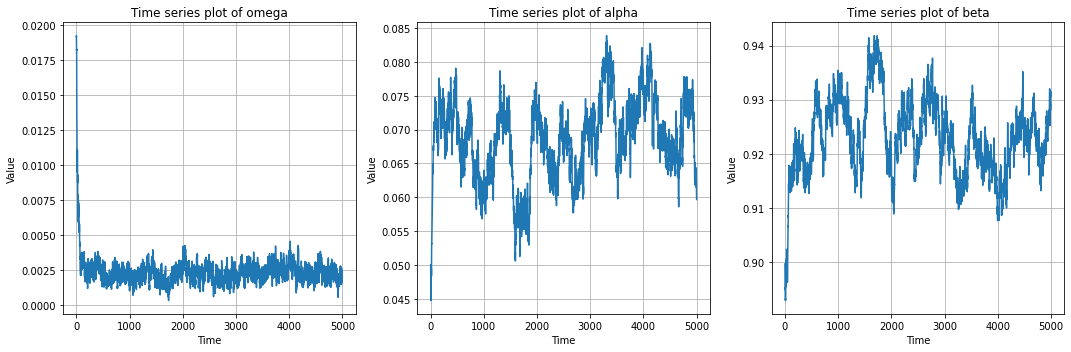

In [1113]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot time series graphs for x1list, x2list and x3list
axs[0].plot(x1list)
axs[0].set_title("Time series plot of omega")
axs[1].plot(x2list)
axs[1].set_title("Time series plot of alpha")
axs[2].plot(x3list)
axs[2].set_title("Time series plot of beta")

# Title and grid settings for time series charts
for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)

# Display time series graphs side by side
plt.tight_layout()
plt.show()

In [1103]:
B = 1000  # amount of burn-in

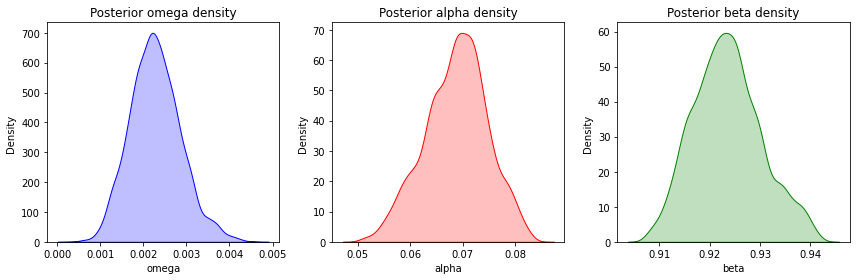

In [1110]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# plot omega
sns.kdeplot(x1list[(B):(len(x1list))], fill=True, color='b', ax=axes[0])
axes[0].set_xlabel('omega')
axes[0].set_ylabel('Density ')
axes[0].set_title('Posterior omega density')

# # plot alpha
sns.kdeplot(x2list[(B):(len(x2list))], fill=True, color='r', ax=axes[1])
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('Density ')
axes[1].set_title('Posterior alpha density')

# # plot beta
sns.kdeplot(x3list[(B):(len(x3list))], fill=True, color='g', ax=axes[2])
axes[2].set_xlabel('beta')
axes[2].set_ylabel('Density ')
axes[2].set_title('Posterior beta density')

# space between graph
plt.tight_layout()

# display
plt.show()

In [1116]:
print("Ran Metropolis algorithm for", M, "iterations, with burn-in", B)
print("Acceptance rate =", numaccept/i)
u = np.mean(x1list[B:len(x1list)])
print("mean of x1 is about", u)
v = np.mean(x2list[B:len(x2list)])
print("mean of x2 is about", v)
w = np.mean(x3list[B:len(x3list)])
print("mean of x3 is about", w)

Ran Metropolis algorithm for 3000 iterations, with burn-in 1000
Acceptance rate = 0.2879189220315559
mean of x1 is about 0.0022759454774031467
mean of x2 is about 0.06868017943691528
mean of x3 is about 0.923467731384925


In [1112]:
# Computation the standard deviations of the x1list, x2list and x3list
se11 = np.std(x1list[(B):(len(x1list))]) / np.sqrt(len(x1list)-B)
se12 = np.std(x2list[(B):(len(x2list))]) / np.sqrt(len(x2list)-B)
se13 = np.std(x3list[(B):(len(x3list))]) / np.sqrt(len(x3list)-B)

# Compute the variance factor of the x1list, x2list and x3list
thevarfact1 = varfact(x1list[(B):(len(x1list))])
thevarfact2 = varfact(x2list[(B):(len(x2list))])
thevarfact3 = varfact(x3list[(B):(len(x3list))])

# Compute the true standard errors of the x1list, x2list and x3list
se1 = se11 * np.sqrt(thevarfact1)
se2 = se12 * np.sqrt(thevarfact2)
se3 = se13 * np.sqrt(thevarfact3)

# Display and compute the 95% confidencce interval
print("true standard error of omega is about", se1)
print("approximate 95% confidence interval of omega is (", u - 1.96 * se1, ",", u + 1.96 * se1, ")\n")

print("true standard error of alpha is about", se2)
print("approximate 95% confidence interval of alpha is (", v - 1.96 * se2, ",", v + 1.96 * se2, ")\n")

print("true standard error of beta is about", se3)
print("approximate 95% confidence interval of beta is (", w - 1.96 * se3, ",", w + 1.96 * se3, ")\n")

true standard error of omega is about 4.8923662543339506e-05
approximate 95% confidence interval of omega is ( 0.002180055098818201 , 0.002371835855988092 )

true standard error of alpha is about 0.0007387329400908504
approximate 95% confidence interval of alpha is ( 0.06723226287433721 , 0.07012809599949334 )

true standard error of beta is about 0.0008393912998887581
approximate 95% confidence interval of beta is ( 0.9218225244371431 , 0.9251129383327069 )



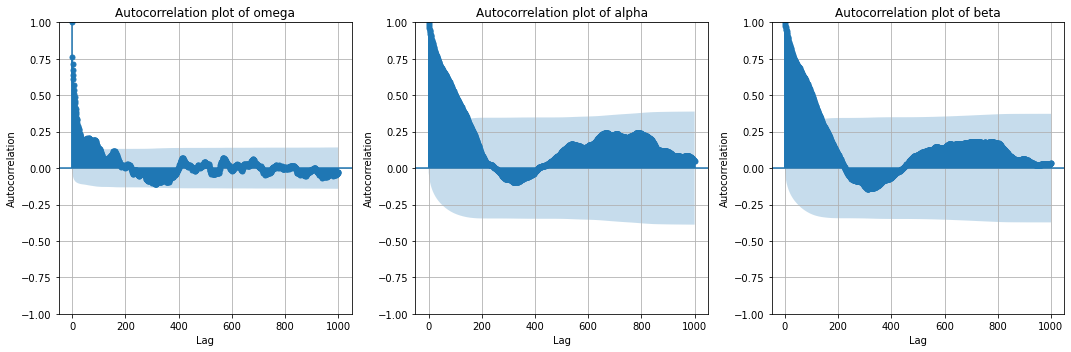

In [1122]:
# Créer une nouvelle figure avec une grille de 1 ligne et 3 colonnes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Tracer les graphiques d'autocorrélation pour x1list, x2list et x3list
plot_acf(x1list[(B):(len(x1list))], ax=axs[0], lags=1000)
axs[0].set_title("Autocorrelation plot of omega")
plot_acf(x2list[(B):(len(x2list))], ax=axs[1], lags=1000)
axs[1].set_title("Autocorrelation plot of alpha")
plot_acf(x3list[(B):(len(x3list))], ax=axs[2], lags=1000)
axs[2].set_title("Autocorrelation plot of beta")

# Réglages des titres et de la grille pour les graphiques d'autocorrélation
for ax in axs:
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    ax.grid(True)

# Afficher les graphiques d'autocorrélation côte à côte
plt.tight_layout()
plt.show()

### Archives